In [ ]:
!pip install einops

In [10]:
import numpy as np 
import einops 
import matplotlib.pyplot as plt 
import cv2 as cv 

In [20]:
imag1 = plt.imread('madara.png')
imag2 = plt.imread('madara.png')
imag11 = cv.resize(imag1,(1920,1080))
imag22 = cv.resize(imag2,(1920,1080))
image = np.array([imag11,imag22])
print(image.shape)

image = einops.reduce(image, 'b (h 10) (w 10) c -> b h w c','mean')
print(image.shape)

(2, 1080, 1920, 3)
(2, 108, 192, 3)


In [16]:
x1 = einops.rearrange(image, 'b h w c -> b c h w')
print(x1.shape)

(2, 3, 108, 192)


In [21]:
ph,pw = 12,12 
x2 = einops.rearrange(image, 'b  (h ph) (w pw) c -> b (h w) ph pw c', ph=ph, pw=pw)
print(x2.shape)

(2, 144, 12, 12, 3)


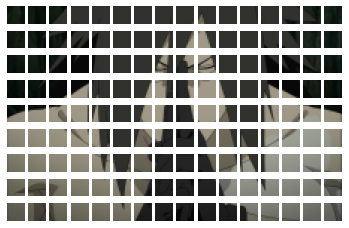

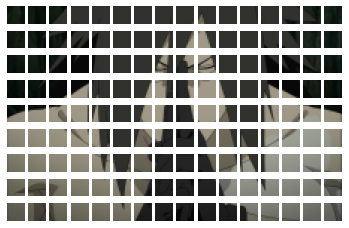

In [22]:
h = 108
w = 192
for img in x2:
  for i,p in enumerate(img):
    plt.subplot(h // ph, w//pw,i+1)
    plt.imshow(p)
    plt.axis('off')
  plt.show()

In [23]:
x3 = einops.rearrange(image, 'b  (h ph) (w pw) c -> b (h w) (ph pw c)' , ph=ph , pw=pw)
print(x3.shape)

(2, 144, 432)


In [64]:
import torch 
from torch import nn 
import torch.nn.functional as F 
import math
from einops.layers.torch import Rearrange

In [36]:
class Attention(nn.Module):
  def __init__(self,d):
    super().__init__()
    self.d = d
    self.Q = nn.Linear(d,d)
    self.K = nn.Linear(d,d)
    self.V = nn.Linear(d,d)

  def forward(self,x):
    q = self.Q(x)
    k = self.K(x)
    v = self.V(x)
    score = F.softmax(torch.matmul(q,k.transpose(1,2)) / math.sqrt(self.d), dim=-1)
    return torch.matmul(score,v)
    

In [38]:
x = torch.rand((2,10,128)) # bat X path X attentionvector 
attention = Attention(x.shape[-1])
a = attention(x)
print(a.shape) 


torch.Size([2, 10, 128])


In [42]:
class MultiheadAttention(nn.Module):
  def __init__(self,head,d):
    super().__init__()
    self.head = head 
    self.d = d 
    self.attentions = nn.ModuleList([])
    for _ in range(head):
      self.attentions.append(Attention(d))
    self.Linear = nn.Linear(head*d ,d)

  def forward(self,x):
    X = []
    for attention in self.attentions:
      X.append(attention(x))
    X = einops.rearrange(X, 'h b p d -> b p (h d)')
    return self.Linear(X)


In [43]:
x = torch.rand((2,10,128))
msa = MultiheadAttention(8,x.shape[-1])
a = msa(x)
print(a.shape)

torch.Size([2, 10, 128])


In [44]:
class Transformers(nn.Module):
  def __init__(self,d,hidden,head=8,n_MSA=2):
    super().__init__()

    self.norm = nn.LayerNorm(d)
    self.MSAs = nn.ModuleList([])
    for _ in range(n_MSA):
      self.MSAs.append(nn.ModuleList([
          MultiheadAttention(head , d),
          nn.Linear(d,hidden),
          nn.Linear(hidden,d)
      ]))
  def forward(self, x):
    for msa , fc1 , fc2 in self.MSAs:
      x = self.norm(msa(x)+x)
      x = self.norm(fc2(F.relu(fc1(x)))+x)
    return x 


In [46]:
x = torch.rand((2,10,128))
batch , path , d = x.shape
transformers = Transformers(d,2*d)
a = transformers(x)
print(a.shape)

torch.Size([2, 10, 128])


In [61]:
class PositionalEncoding(nn.Module):
  def __init__(self , d , patch):
    super().__init__()
    pe = torch.zeros(patch , d)
    pos = torch.arange(0,patch,dtype=torch.float).unsqueeze(1)
    inv_divisor = torch.exp(torch.arange(0,d,2,dtype=torch.float) * -math.log(10000.0)/d)
    pe[:, 0::2] = torch.sin(pos * inv_divisor)
    pe[:, 1::2] = torch.cos(pos * inv_divisor)
    pe = pe.unsqueeze(0)

    self.register_buffer('pe', pe)

  def forward(self ,x ):
    return  x + self.pe[:,:x.size(1)]


In [62]:
x = torch.rand((2,10,128))
batch , path , d = x.shape
pos = PositionalEncoding(d, path)
x = pos(x)
transformers = Transformers(d,2*d)
a = transformers(x)
print(a.shape)

torch.Size([2, 10, 128])


In [76]:
class VIT(nn.Module):
  def __init__(self, image_size=(224,224) , patch_size=(16,16), channel=3, d=128, classes=1000 ):
    super().__init__()
    self.patch = nn.Sequential(
        Rearrange('b c (h ph) (w pw) -> b (h w) ( ph pw c)',ph=patch_size[0],pw=patch_size[1]),
        nn.Linear(patch_size[0] * patch_size[1] * channel , d),
    )
    patch = (image_size[0] // patch_size[0]) * (image_size[1] // patch_size[1])
    self.pos = PositionalEncoding(d , patch+1)
    self.cls = nn.Parameter(torch.rand(1,1,d))
    self.transformers = Transformers(d, 2*d)
    self.norm = nn.LayerNorm(d)
    self.fc = nn.Linear(d, classes)
  
  def forward(self, x):
    x = self.patch(x)
    b , patch , d = x.shape
    cls = einops.repeat(self.cls,'1 p d -> b p d',b=b)
    x = torch.cat((cls,x),dim=1)

    x = self.pos(x)
    x = self.transformers(x)
    x = x[:, 0]

    x = self.fc(self.norm(x))

    return F.softmax(x,dim=-1)


In [79]:
x = torch.rand((10,3,224,224))
vit = VIT()
x = vit(x)
print(x.shape)

torch.Size([10, 1000])
